<a href="https://colab.research.google.com/github/nguyen-brat/Devide-Subject-and-predicate-in-vietnamese-automatic/blob/main/mask_language_modeling.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#IMPORT

In [1]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
import os
import pandas as pd
import re
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [2]:
mask_percent = 0.15 # percent data replace with mask
train_size = 0.8
valid_size = 0.1
test_size = 0.1
max_len = 256 # max len of input feed to neuron network
max_dim = 128 # world embedding dimention
batch_size = 32
num_epochs = 4
n_blocks = 2 # n transformer block
lr = 0.01 # learning rate
n_heads = 8 # n_head in transformer block
drop_rate = 0.1 # drop rate in transformer block
freq_word = 30 # remove all world below freq_word
d_dim = 256 # dimention in FFN layers

# PREPROCESSING

In [3]:
from google.colab import drive
drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [4]:
#!unzip /content/drive/MyDrive/book_text.zip -d /content

In [5]:
list_data = []
with open('/content/booksummaries.txt', 'r') as f:
  data = f.readlines()
  for line in data:
    list_data.append(line.split('\t')[6])

In [6]:
list_data[0]

' Old Major, the old boar on the Manor Farm, calls the animals on the farm for a meeting, where he compares the humans to parasites and teaches the animals a revolutionary song, \'Beasts of England\'. When Major dies, two young pigs, Snowball and Napoleon, assume command and turn his dream into a philosophy. The animals revolt and drive the drunken and irresponsible Mr Jones from the farm, renaming it "Animal Farm". They adopt Seven Commandments of Animal-ism, the most important of which is, "All animals are equal". Snowball attempts to teach the animals reading and writing; food is plentiful, and the farm runs smoothly. The pigs elevate themselves to positions of leadership and set aside special food items, ostensibly for their personal health. Napoleon takes the pups from the farm dogs and trains them privately. Napoleon and Snowball struggle for leadership. When Snowball announces his plans to build a windmill, Napoleon has his dogs chase Snowball away and declares himself leader. N

In [7]:
for i, line in enumerate(list_data):
  list_data[i] = list_data[i][:-2].lower()
  list_data[i] = re.sub('[^a-zA-Z0-9\s]', '' ,list_data[i])

In [8]:
list_data[0]

' old major the old boar on the manor farm calls the animals on the farm for a meeting where he compares the humans to parasites and teaches the animals a revolutionary song beasts of england when major dies two young pigs snowball and napoleon assume command and turn his dream into a philosophy the animals revolt and drive the drunken and irresponsible mr jones from the farm renaming it animal farm they adopt seven commandments of animalism the most important of which is all animals are equal snowball attempts to teach the animals reading and writing food is plentiful and the farm runs smoothly the pigs elevate themselves to positions of leadership and set aside special food items ostensibly for their personal health napoleon takes the pups from the farm dogs and trains them privately napoleon and snowball struggle for leadership when snowball announces his plans to build a windmill napoleon has his dogs chase snowball away and declares himself leader napoleon enacts changes to the go

In [9]:
corpus = set()
for data in list_data:
  corpus.update(data.split())

In [10]:
corpus_freq = {word : 0 for word in corpus}
for data in list_data:
  for word in data.split():
    corpus_freq[word] += 1

In [11]:
short_corpus = [word for word, freq in corpus_freq.items() if freq > freq_word]
eliminate_corpus = [word for word, freq in corpus_freq.items() if freq <= freq_word]
short_corpus = ['[PAD]', '[MASK]'] + short_corpus

In [12]:
words = tf.constant(short_corpus)
word_ids = tf.range(len(short_corpus), dtype=tf.int64)
vocab_init = tf.lookup.KeyValueTensorInitializer(words, word_ids)
num_oov_buckets = 1000
table = tf.lookup.StaticVocabularyTable(vocab_init, num_oov_buckets)

In [13]:
corpus_len = len(short_corpus) + num_oov_buckets

In [14]:
train_data, valid_data = train_test_split(list_data, train_size = train_size, test_size = test_size+valid_size, random_state = 42)
valid_data, test_data =  train_test_split(valid_data, train_size = valid_size/(valid_size+test_size), test_size=test_size/(valid_size+test_size), random_state = 42)

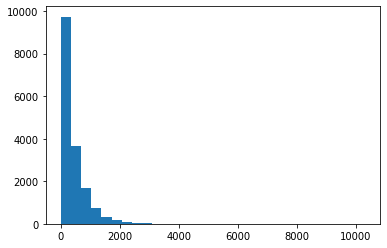

In [15]:
list_len = np.array([len(data.split()) for data in list_data])
plt.hist(np.array(list_len), bins = 30)
plt.show()

In [16]:
def MaskingData(texts, mask_rate = mask_percent):
  mask_texts = []
  one_hot_masks = []
  non_masks = []
  for text in texts:
    text = text.split()
    random_mask_id = np.random.randint(0, len(text), size = int(len(text)*mask_rate))
    one_hot_mask = np.zeros(shape = len(text))
    one_hot_mask[random_mask_id] = 1
    one_hot_masks.append(one_hot_mask)
    text = np.array(text)
    raw_text = np.copy(text)
    text[random_mask_id] = '[MASK]'
    mask_texts.append(text)
    non_masks.append(raw_text)
  return non_masks, mask_texts, one_hot_masks

In [17]:
mask_id = short_corpus.index('[MASK]')
def encode_sentence(text):
  return list(table.lookup(tf.constant(text.split())).numpy())
def encode_sentences(texts):
  output = []
  for text in texts:
    output.append(table.lookup(tf.constant(text)).numpy())
  return output

In [18]:
def PaddingData(encode_non_mask_texts, encode_mask_texts, mask_ids, max_len = max_len):
  padding_ids = []
  pad_masks = []
  pad_mask_texts = []
  pad_non_mask_texts = []
  for mask_text, non_mask_text, mask_id in zip(encode_mask_texts, encode_non_mask_texts, mask_ids):
    add_padding = max_len - len(mask_text)%max_len
    size = add_padding + len(mask_text)
    padding_id = np.ones(size)
    padding_id[len(mask_text):] = 0
    mask_text     = np.pad(mask_text,     (0, add_padding), 'constant', constant_values=(0, 0))
    mask_id       = np.pad(mask_id,       (0, add_padding), 'constant', constant_values=(0, 0))
    non_mask_text = np.pad(non_mask_text, (0, add_padding), 'constant', constant_values=(0, 0))

    padding_id = padding_id.reshape(-1, max_len)
    mask_id = mask_id.reshape(-1, max_len)
    mask_text = mask_text.reshape(-1, max_len)
    non_mask_text = non_mask_text.reshape(-1, max_len)

    padding_ids.append(padding_id)
    pad_masks.append(mask_id)
    pad_mask_texts.append(mask_text)
    pad_non_mask_texts.append(non_mask_text)
  
  padding_id = np.concatenate(padding_ids, axis = 0)
  pad_mask = np.concatenate(pad_masks, axis = 0)
  pad_mask_text = np.concatenate(pad_mask_texts, axis = 0)
  pad_non_mask_text = np.concatenate(pad_non_mask_texts, axis = 0)

  return pad_non_mask_text, pad_mask_text, padding_id, pad_mask

In [19]:
def Padding_inference(text):
  text_len = len(text)
  add_padding = max_len - len(text)%max_len
  size = add_padding + len(text)
  text = np.pad(text, (0, add_padding), 'constant', constant_values=(0, 0))
  pad_id = np.zeros(shape = (1, max_len), dtype = np.float32)
  pad_id[:, :text_len] = 1
  return text.reshape(1, max_len), pad_id

In [20]:
def decode_sentence(tensor):
  output = []
  for value in tensor:
    if value < len(short_corpus):
      output.append(short_corpus[value])
    else:
      output.append(eliminate_corpus[value])
  return ' '.join(output)

In [70]:
def preprocess(texts, batch_size = batch_size, dtype = tf.float32):
  non_mask_data, mask_data, mask_id = MaskingData(texts)
  input = encode_sentences(mask_data)
  label = encode_sentences(non_mask_data)
  non_mask_text, mask_text, padding_id, pad_mask = PaddingData(label, input, mask_id)

  non_mask_text = tf.convert_to_tensor(non_mask_text, dtype = dtype)
  mask_text = tf.convert_to_tensor(mask_text, dtype = dtype)
  padding_id = tf.convert_to_tensor(padding_id, dtype = dtype)
  pad_mask = tf.convert_to_tensor(pad_mask, dtype = dtype)

  non_mask_text = tf.data.Dataset.from_tensor_slices(non_mask_text)
  mask_text = tf.data.Dataset.from_tensor_slices(mask_text)
  padding_id = tf.data.Dataset.from_tensor_slices(padding_id)
  pad_mask = tf.data.Dataset.from_tensor_slices(pad_mask)

  dataset = tf.data.Dataset.zip((non_mask_text, mask_text, padding_id, pad_mask)).shuffle(1000).batch(batch_size, drop_remainder=True)
  
  return dataset

def Preprocess(texts, batch_size = batch_size, dtype = tf.float32):
  non_mask_data, mask_data, mask_id = MaskingData(texts)
  input = encode_sentences(mask_data)
  label = encode_sentences(non_mask_data)
  non_mask_text, mask_text, padding_id, pad_mask = PaddingData(label, input, mask_id)

  non_mask_text = tf.convert_to_tensor(non_mask_text, dtype = dtype)
  mask_text = tf.convert_to_tensor(mask_text, dtype = dtype)
  pad_mask = tf.convert_to_tensor(pad_mask, dtype = dtype)

  return mask_text, non_mask_text, pad_mask

In [71]:
Train_dataset = Preprocess(train_data)
Valid_dataset = Preprocess(valid_data)
Test_dataset = Preprocess(test_data)

In [22]:
train_dataset = preprocess(train_data)
valid_dataset = preprocess(valid_data)
test_dataset = preprocess(test_data)

# BUILD MODEL

In [33]:
class PositionalEncoding(keras.layers.Layer):
    def __init__(self, max_steps, max_dims, dtype=tf.float32, **kwargs):
        super().__init__(dtype=dtype, **kwargs)
        if max_dims % 2 == 1: max_dims += 1 # max_dims must be even
        p, i = np.meshgrid(np.arange(max_steps), np.arange(max_dims // 2))
        pos_emb = np.empty((1, max_steps, max_dims))
        pos_emb[0, :, ::2] = np.sin(p / 10000**(2 * i / max_dims)).T
        pos_emb[0, :, 1::2] = np.cos(p / 10000**(2 * i / max_dims)).T
        self.positional_embedding = tf.constant(pos_emb.astype(self.dtype))
    def call(self, inputs):
        shape = tf.shape(inputs)
        return inputs + self.positional_embedding[:, :shape[-2], :shape[-1]]

In [34]:
class MultiheadAttention(keras.layers.Layer):
  def __init__(self, n_heads = 8, dropout_rate = 0.1, **kwargs):
    super(MultiheadAttention, self).__init__()
    self.n_heads = n_heads
    self.dropout_rate = dropout_rate
  def build(self, batch_input_shape):
    self.batch, self.q_time_steps, self.dim = batch_input_shape[0]
    self.q_linear = keras.layers.Conv1D(self.dim * self.n_heads, kernel_size = 1, strides = 1, padding = 'valid', use_bias = False)
    self.k_linear = keras.layers.Conv1D(self.dim * self.n_heads, kernel_size = 1, strides = 1, padding = 'valid', use_bias = False)
    self.v_linear = keras.layers.Conv1D(self.dim * self.n_heads, kernel_size = 1, strides = 1, padding = 'valid', use_bias = False)
    self.linear_out = keras.layers.Conv1D(self.dim, kernel_size = 1, strides = 1, padding = 'valid', use_bias = False)
    self.drop_out = keras.layers.Dropout(self.dropout_rate)
    super().build(batch_input_shape)
  def mask_attention(self, q, k, v, mask_q = None, mask_k = None):
    if mask_q is None:
      mask_q = tf.ones(shape = (q.shape[0], q.shape[1], q.shape[2]))
    else:
      dim = q.shape[2]
      time_series = q.shape[1]
      mask_q = tf.stack([mask_q]*self.n_heads*dim, axis = 0)
      mask_q = tf.reshape(mask_q, shape = (dim, self.n_heads, self.batch, time_series)) # dim-n_heads-batch-time_series
      mask_q = tf.transpose(mask_q, perm = [2, 1, 3, 0])
      mask_q = tf.reshape(mask_q, shape = (self.batch*self.n_heads, time_series, dim))
    if mask_k is None:
      mask_k = tf.ones(shape = (k.shape[0], k.shape[1], k.shape[2]))
    else:
      dim = k.shape[2]
      time_series = k.shape[1]
      mask_k = tf.stack([mask_k]*self.n_heads*dim, axis = 0)
      mask_k = tf.reshape(mask_k, shape = (dim, self.n_heads, self.batch, time_series)) # dim-n_heads-batch-time_series
      mask_k = tf.transpose(mask_k, perm = [2, 1, 3, 0])
      mask_k = tf.reshape(mask_k, shape = (self.batch*self.n_heads, time_series, dim))
    q = tf.multiply(q, mask_q)
    k = tf.multiply(k, mask_k)
    v = tf.multiply(v, mask_k)
    normalize = tf.math.sqrt(tf.cast(self.dim, dtype=tf.float32))
    attention = tf.linalg.matmul(q, tf.transpose(k, perm = [0, 2, 1])) / normalize
    norm_attention = tf.nn.softmax(attention, axis = -1)
    output = tf.linalg.matmul(norm_attention, v)
    return output, norm_attention
  def linear_attention(self, input, linear):
    timestep = input.shape[1]
    output = linear(input)
    output = tf.reshape(output, shape = [self.batch, timestep, self.n_heads, self.dim])
    output = tf.transpose(output, perm = [0, 2, 1, 3])
    output = tf.reshape(output, shape = [self.batch * self.n_heads, timestep, self.dim])
    return output
  def call(self, inputs, mask_q = None, mask_k = None):
    if len(inputs) == 1:
      Q,K,V = inputs*3
    else: # query and value
      Q = inputs[0]
      K = inputs[1]
      V = inputs[1]
    Q = self.linear_attention(Q, self.q_linear)
    K = self.linear_attention(K, self.k_linear)
    V = self.linear_attention(V, self.v_linear)
    output, attention_weight = self.mask_attention(Q, K, V, mask_q = mask_q, mask_k = mask_k)
    output = tf.reshape(output, shape = [self.batch, self.n_heads, self.q_time_steps, self.dim])
    output = tf.transpose(output, perm = [0, 2, 1, 3])
    output = tf.reshape(output, shape = [self.batch, self.q_time_steps, self.n_heads*self.dim])
    output = self.linear_out(output)
    output = self.drop_out(output)
    return output, attention_weight

In [67]:
class FFN(keras.layers.Layer):
  def __init__(self, d_dim = d_dim, drop_rate = drop_rate):
    super().__init__()
    self.d_dim = d_dim
    self.drop = keras.layers.Dropout(drop_rate)
    self.normalize = keras.layers.LayerNormalization(epsilon=1e-6)
  def build(self, batch_input_shape):
    self.dense = keras.layers.Dense(self.d_dim, activation = 'relu')
    self.d_model = keras.layers.Dense(batch_input_shape[-1])
  def call(self, input):
    emb = self.dense(input)
    bottle_neck = self.d_model(emb)
    add = bottle_neck + input
    normalize = self.normalize(add)
    output = self.drop(normalize)
    return output

In [68]:
class transformer_block(keras.layers.Layer):
  def __init__(self, n_heads = n_heads, drop_rate = drop_rate, d_dim = d_dim):
    super(transformer_block, self).__init__()
    self.n_heads = n_heads
    self.drop_rate = drop_rate
    #self.MulAttention = MultiheadAttention(n_heads, drop_rate)
    self.MulAttention = keras.layers.MultiHeadAttention(num_heads = n_heads, key_dim = d_dim)
    self.ffn = FFN(d_dim, drop_rate)
    self.normalize = keras.layers.LayerNormalization(epsilon=1e-6)
  def call(self, inputs, mask_q = None, mask_k = None):
    #x, attention_weight = self.MulAttention(inputs, mask_q, mask_k)
    x = self.MulAttention(inputs, inputs)
    x = x + inputs
    normalize = self.normalize(x)
    output = self.ffn(normalize)
    return output

In [37]:
# dump_inp = tf.random.uniform(shape = (batch_size, max_len, max_dim))
# dump_2d_inp = tf.random.uniform(shape = (batch_size, max_len))

In [69]:
class MaskLanguageModel(keras.Model):
  def __init__(self, d_dim = d_dim, vocab_size = corpus_len ,max_steps = max_len, max_dims = max_dim, n_heads = n_heads, drop_rate = drop_rate, n_blocks = n_blocks):
    super().__init__()
    self.position = PositionalEncoding(max_steps = max_steps, max_dims = max_dims)
    self.transformers = [transformer_block(n_heads = n_heads, drop_rate = drop_rate, d_dim = d_dim) for _ in range(n_blocks)]
    self.dense = keras.layers.Dense(vocab_size)
    self.embed = keras.layers.Embedding(vocab_size, max_dims, input_length = max_steps)
  def call(self, inputs, mask_q = None, mask_k = None, training = False):
    embed = self.embed(inputs)
    pos_emb = self.position(embed)
    x = self.transformers[0](pos_emb, mask_q, mask_k)
    for block in self.transformers[1:]:
      x = block(x)
    output = self.dense(x)
    output = tf.nn.softmax(output, axis = -1)
    return output

In [39]:
# test_model = MaskLanguageModel()
# test_model(dump_2d_inp).shape
# test_model.summary()

# CUSTOM TRAINING LOOP (something got trouble with custom training loop)

In [40]:
model = MaskLanguageModel()
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.experimental.AdamW()
metrics_train = keras.metrics.SparseCategoricalAccuracy()
metrics_test  = keras.metrics.SparseCategoricalAccuracy()
#model.build((batch_size, max_len))
@tf.function
def train_step(input, label):
  with tf.GradientTape() as tape:
    #output = model([input], mask_q = padding_id, mask_k = padding_id, training = True)
    output = model(input)
    loss = loss_fn(label, output, sample_weight = pad_mask)
  grads = tape.gradient(loss, model.trainable_weights)
  optimizer.apply_gradients(zip(grads, model.trainable_weights))
  metrics_train.update_state(label, output, sample_weight = pad_mask)
  return loss

@tf.function
def test_step(input, label):
  #output = model([input], mask_q = padding_id, mask_k = padding_id, training = False)
  output = model(input)
  metrics_test.update_state(label, output, sample_weight = pad_mask)

In [41]:
list_loss = []
train_acc = []
valid_acc = []
for i in range(num_epochs):
  print(f'epoch {i+1}/{num_epochs}: ', end = ' ')
  for label, input, padding_id, pad_mask in tqdm(train_dataset):
    loss = train_step(input, label)
    list_loss.append(loss.numpy())
  print(f'The training loss is {loss}')
  print(f'The training accuracy is {metrics_train.result()}')
  train_acc.append(metrics_train.result())
  metrics_train.reset_states()

  for label, input, padding_id, pad_mask in valid_dataset:
    test_step(input, label)
  print(f'The valid accuracy is {metrics_test.result()}')
  valid_acc.append(metrics_test.result())
  metrics_test.reset_states()

epoch 1/4:  

100%|██████████| 920/920 [03:44<00:00,  4.10it/s]


The training loss is 0.71457839012146
The training accuracy is 0.2183450609445572
The valid accuracy is 0.22104774415493011
epoch 2/4:  

100%|██████████| 920/920 [02:56<00:00,  5.21it/s]


The training loss is 0.6455916166305542
The training accuracy is 0.22056061029434204
The valid accuracy is 0.22254572808742523
epoch 3/4:  

100%|██████████| 920/920 [02:49<00:00,  5.44it/s]


The training loss is 0.658482551574707
The training accuracy is 0.21913591027259827
The valid accuracy is 0.22322088479995728
epoch 4/4:  

100%|██████████| 920/920 [02:47<00:00,  5.48it/s]


The training loss is 0.6833505630493164
The training accuracy is 0.21943439543247223
The valid accuracy is 0.22016161680221558


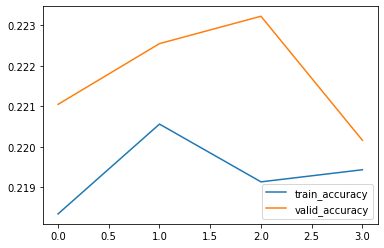

In [42]:
plt.plot(train_acc, label = 'train_accuracy')
plt.plot(valid_acc, label = 'valid_accuracy')
plt.legend()
plt.show()

# FIT TRAINING LOOP

In [74]:
loss_fn = keras.losses.SparseCategoricalCrossentropy()
optimizer = keras.optimizers.experimental.AdamW()
mask_text, non_mask_text, pad_id = Train_dataset
model = MaskLanguageModel()
model.compile(loss = loss_fn, 
              optimizer = optimizer, 
              loss_weights = pad_id
              )
history = model.fit(mask_text, non_mask_text, 
                    epochs = 5, 
                    batch_size = batch_size
                    )

Epoch 1/3
921/921 [==============================] - 171s 178ms/step - loss: 0.5070
Epoch 2/3
921/921 [==============================] - 152s 165ms/step - loss: 0.3677
Epoch 3/3
921/921 [==============================] - 155s 168ms/step - loss: 0.3387


# Testing

In [97]:
def inference(text):
  text = text.lower()
  mask_id = text.split().index('[mask]')
  encode = encode_sentence(text)
  padding, pad_id = Padding_inference(encode)
  output = model(padding.reshape(1, max_len)).numpy()
  result = np.argmax(output, axis = -1)
  decode = decode_sentence(result[0][:len(text.split())])
  return decode.split()[mask_id]

In [99]:
inference('How are [mask] today')

'furnivals'